In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import yfinance as yf
from sklearn.cluster import KMeans
from colorama import Fore, Style
import seaborn as sns
sns.set(style='darkgrid')
import plotly.graph_objects as go
import pickle

import sys
sys.path.append('../src') 
from stock_strategy import stock_strategy

from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import fsolve

from kneed import KneeLocator

## Moving Averages and Bollinger Band -- Exploration

In [2]:
def plot_stock(stock_name,
               start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d'),
               end=datetime.today(),
               figsize=(12, 6),
               interactive=False,
               return_result=False,
              ):
    '''
    Input:
    stock_name: str
    start: datetime
    end: datetime
    '''
    df = yf.download(stock_name.upper(),
                     start=start,
                     end=end)
    df = df.reset_index()
    df.columns = df.columns.str.lower()
    
    df['20 Day MA'] = df['close'].rolling(window=20).mean()
    df['20 Day STD'] = df['close'].rolling(window=20).std()
    df['50 Day MA'] = df['close'].rolling(window=50).mean()
    df['50 Day STD'] = df['close'].rolling(window=50).std()
    df['12 Day EMA'] = df['close'].ewm(span=12, adjust=False).mean()
    df['26 Day EMA'] = df['close'].ewm(span=26, adjust=False).mean()
    df['50 Day EMA'] = df['close'].ewm(span=50, adjust=False).mean()
    df['200 Day EMA'] = df['close'].ewm(span=200, adjust=False).mean()
    # Calculate upper and lower bands
    df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
    df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)

    close = df.iloc[-1]['close']
    print('* previous stock price closing', round(close,2))
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest 50 Day MA:", df['50 Day MA'].tolist()[-1])

    print("Latest Lower Bollinger Band - 20MA:", df['Lower Band - 20MA'].tolist()[-1])
    print("Latest Higher Bollinger Band - 20MA:", df['Upper Band - 20MA'].tolist()[-1])
    print("Latest Lower Bollinger Band - 50MA:", df['Lower Band - 50MA'].tolist()[-1])
    print("Latest Higher Bollinger Band - 50MA:", df['Upper Band - 50MA'].tolist()[-1])

    df_plot = df[df['date'] >= df['date'].min() + relativedelta(years=1)]
    if interactive:
        fig = go.Figure(layout=dict(width=figsize[0]*80, height=figsize[1]*80))
        
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['close'], name='Daily Price'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['20 Day MA'], mode='lines', line=dict(dash='dash'), name='20 Day MA'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['Lower Band - 20MA'], mode='lines', line=dict(dash='dash'), name='Lower Band - 20MA'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['Upper Band - 20MA'], mode='lines', line=dict(dash='dash'), name='Upper Band - 20MA', fill='tonexty', fillcolor='rgba(128,128,128,0.3)'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['50 Day MA'], mode='lines', line=dict(dash='dash'), name='50 Day MA'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['Lower Band - 50MA'], mode='lines', line=dict(dash='dash'), name='Lower Band - 50MA'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['Upper Band - 50MA'], mode='lines', line=dict(dash='dash'), name='Upper Band - 50MA', fill='tonexty', fillcolor='rgba(128,128,128,0.15)'))

        fig.update_layout(title='Interactive Plot of Daily Stock Price for ' + stock_name,
                          xaxis_title='date',
                          yaxis_title='Daily Price',
                          hovermode='closest')
        
        # Add ability to select a single data point
        fig.update_traces(marker=dict(size=10, opacity=0.8),
                          selector=dict(mode='markers'))
        
        fig.show()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        ax.grid(True, alpha=0.5)
    
        ax.plot(df_plot['date'], df_plot['close'], label='Daily Close Price')
        ax.plot(df_plot['date'], df_plot['20 Day MA'], ls='--', label='20 Day Moving Average')
        ax.plot(df_plot['date'], df_plot['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band - 20MA')
        ax.plot(df_plot['date'], df_plot['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band - 20MA')
        ax.fill_between(df_plot['date'], df_plot['Upper Band - 20MA'], df_plot['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
        ax.plot(df_plot['date'], df_plot['50 Day MA'], ls='--', label='50 Day Moving Average')
        ax.plot(df_plot['date'], df_plot['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band - 50MA')
        ax.plot(df_plot['date'], df_plot['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band - 50MA')
        ax.fill_between(df_plot['date'], df_plot['Upper Band - 50MA'], df_plot['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands
    
        ax.set_title('Daily stock price for ' + stock_name.upper())
        ax.legend()
    if return_result:
        return df

[*********************100%%**********************]  1 of 1 completed

* previous stock price closing 75.64
Latest 20 Day MA: 79.94544067382813
Latest 50 Day MA: 76.08257629394531
Latest Lower Bollinger Band - 20MA: 73.53371224660164
Latest Higher Bollinger Band - 20MA: 86.35716910105462
Latest Lower Bollinger Band - 50MA: 65.000395810626
Latest Higher Bollinger Band - 50MA: 87.16475677726461


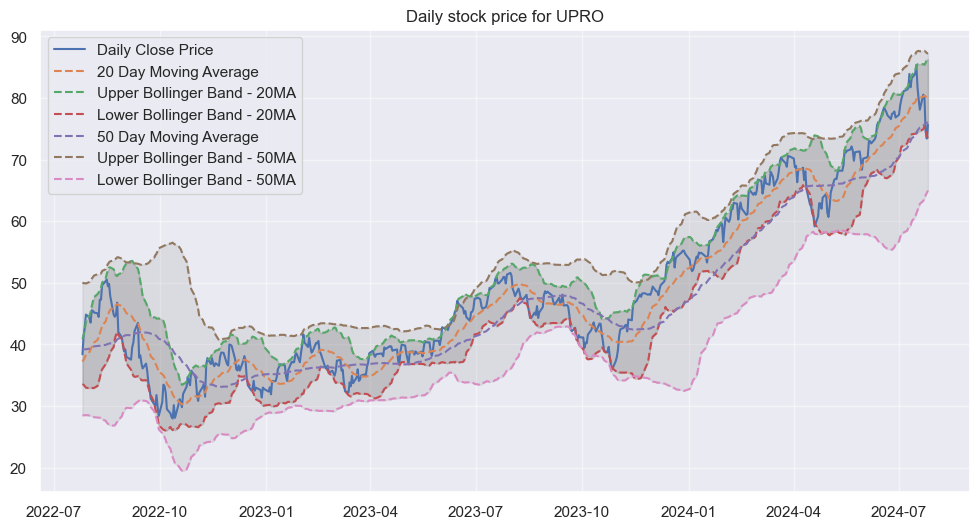

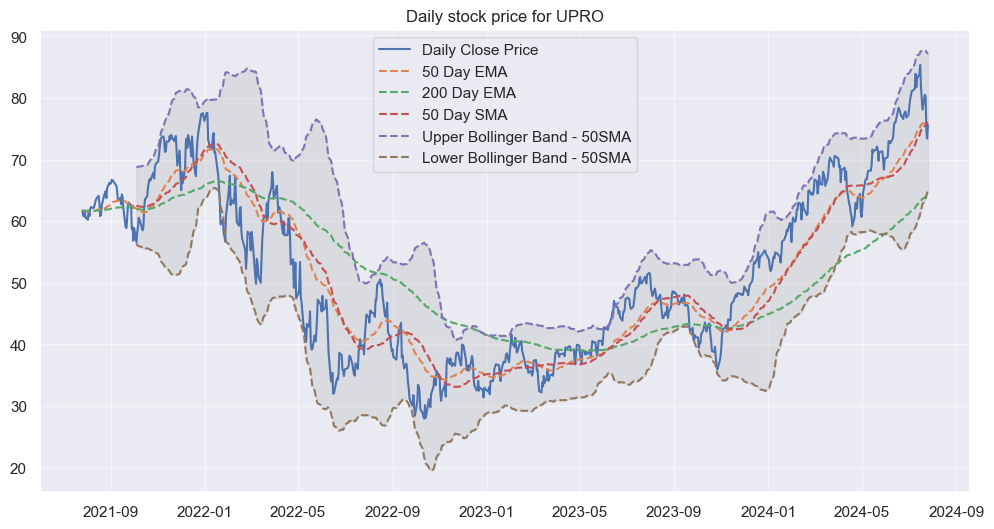

In [3]:
df_plot = plot_stock('upro', return_result=True)
fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True, alpha=0.5)

ax.plot(df_plot['date'], df_plot['close'], label='Daily Close Price')
ax.plot(df_plot['date'], df_plot['50 Day EMA'], ls='--', label='50 Day EMA')
ax.plot(df_plot['date'], df_plot['200 Day EMA'], ls='--', label='200 Day EMA')
ax.plot(df_plot['date'], df_plot['50 Day MA'], ls='--', label='50 Day SMA')
ax.plot(df_plot['date'], df_plot['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band - 50SMA')
ax.plot(df_plot['date'], df_plot['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band - 50SMA')
ax.fill_between(df_plot['date'], df_plot['Upper Band - 50MA'], df_plot['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

ax.set_title('Daily stock price for ' + 'UPRO')
ax.legend()

In [4]:
def update_ma_bb(stock_name):
    '''
    Use real price to update the mas and bollinger band values
    stock_name: str
    '''
    df = yf.download(stock_name.upper(),
                     start=(datetime.today() - relativedelta(days=100)).strftime('%Y-%m-%d'),
                     end=datetime.today()
                     )
    df = df.reset_index()
    df.columns = df.columns.str.lower()
    df = df[['close']]

    ticker = yf.Ticker(stock_name.upper())
    todays_data = ticker.history(period='1d')
    price = todays_data['Close'][-1]

    df.loc[len(df.index)] = [price]  

    df['20 Day MA'] = df['close'].rolling(window=20).mean()
    df['20 Day STD'] = df['close'].rolling(window=20).std()
    df['50 Day MA'] = df['close'].rolling(window=50).mean()
    df['50 Day STD'] = df['close'].rolling(window=50).std()
    
    # Calculate upper and lower bands
    df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
    df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)

    print('Current price:', price)
    print('Current 20MA:', df['20 Day MA'].tolist()[-1])
    print('Current 50MA:', df['50 Day MA'].tolist()[-1])
    print('Current Upper Band - 20MA:', df['Upper Band - 20MA'].tolist()[-1])
    print('Current Lower Band - 20MA:', df['Lower Band - 20MA'].tolist()[-1])
    print('Current Upper Band - 50MA:', df['Upper Band - 50MA'].tolist()[-1])
    print('Current Lower Band - 50MA:', df['Lower Band - 50MA'].tolist()[-1])

update_ma_bb('spy')

[*********************100%%**********************]  1 of 1 completed

Current price: 543.9299926757812
Current 20MA: 552.5120025634766
Current 50MA: 542.6083996582031
Current Upper Band - 20MA: 566.8963680997373
Current Lower Band - 20MA: 538.1276370272159
Current Upper Band - 50MA: 570.4767993093552
Current Lower Band - 50MA: 514.740000007051



/var/folders/37/4klns0v969g2nzh5q5wcpwl00000gn/T/ipykernel_17582/3908085272.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price = todays_data['Close'][-1]


In [5]:
import numpy as np
from scipy.optimize import fsolve

def break_point_solution(stock_name):
    '''
    Solve for the break point solution price for breaking the current MA/BB
    stock_name: str
    '''
    df = yf.download(stock_name.upper(),
                 start=(datetime.today() - relativedelta(days=100)).strftime('%Y-%m-%d'),
                 end=datetime.today()
                 )
    df = df.reset_index()
    df.columns = df.columns.str.lower()
    df = df[['close']]
    
    # Define the expression whose roots we want to find
    # fsolve is not satisfying; provide analytical solution
    
    last_19day_price = df['close'][-20:-1]
    last_49day_price = df['close'][-50:-1]
    
    # func_20MA = lambda price : (np.sum(last_19day_price) + price)/20 - price
    # func_50MA = lambda price : (np.sum(last_49day_price) + price)/50 - price
    # func_20MA_UBB = lambda price : (np.sum(last_19day_price) + price)/20 + 2*np.sqrt((np.sum(last_19day_price**2) + price**2 - (np.sum(last_19day_price) + price)**2/20)/19) - price
    # func_20MA_LBB = lambda price : (np.sum(last_19day_price) + price)/20 - 2*np.sqrt((np.sum(last_19day_price**2) + price**2 - (np.sum(last_19day_price) + price)**2/20)/19) - price
    # func_50MA_UBB = lambda price : (np.sum(last_49day_price) + price)/50 + 2.5*np.sqrt((np.sum(last_49day_price**2) + price**2 - (np.sum(last_49day_price) + price)**2/50)/49) - price
    # func_50MA_LBB = lambda price : (np.sum(last_49day_price) + price)/50 - 2.5*np.sqrt((np.sum(last_49day_price**2) + price**2 - (np.sum(last_49day_price) + price)**2/50)/49) - price

    # func_20MA = lambda price : np.mean(np.append(last_19day_price, price)) - price
    # func_50MA = lambda price : np.mean(np.append(last_49day_price, price)) - price
    # func_20MA_UBB = lambda price : np.mean(np.append(last_19day_price, price)) + 2 * np.std(np.append(last_19day_price, price), ddof=1) - price
    # func_20MA_LBB = lambda price : np.mean(np.append(last_19day_price, price)) - 2 * np.std(np.append(last_19day_price, price), ddof=1) - price
    # func_50MA_UBB = lambda price : np.mean(np.append(last_49day_price, price)) + 2.5 * np.std(np.append(last_49day_price, price), ddof=1) - price
    # func_50MA_LBB = lambda price : np.mean(np.append(last_49day_price, price)) - 2.5 * np.std(np.append(last_49day_price, price), ddof=1) - price

    # price_initial_guess = df['close'].tolist()[-1]
    # price_solution = fsolve(func_20MA, price_initial_guess)
    # price_solution = fsolve(func_50MA, price_initial_guess)
    # price_solution = fsolve(func_20MA_UBB, price_initial_guess)
    # price_solution = fsolve(func_20MA_LBB, price_initial_guess)
    # price_solution = fsolve(func_50MA_UBB, price_initial_guess)
    # price_solution = fsolve(func_50MA_LBB, price_initial_guess)

    a1 = np.sum(last_19day_price)
    a2 = np.sum(last_19day_price**2)
    p_ma = np.mean(last_19day_price)
    p_ubb = (562*a1 + np.sqrt((562*a1)**2 - 4*(5339*(99*a1**2-1600*a2))))/5339/2
    p_lbb = (562*a1 - np.sqrt((562*a1)**2 - 4*(5339*(99*a1**2-1600*a2))))/5339/2
    
    print('20MA break point:', p_ma.round(2))
    print('20MA Lower Bollinger Band break point:', p_lbb.round(2))
    print('20MA Upper Bollinger Band break point:', p_ubb.round(2))

    a1 = np.sum(last_49day_price)
    a2 = np.sum(last_49day_price**2)
    p_ma = np.mean(last_49day_price)
    p_ubb = (4177*a1 + np.sqrt((4177*a1)**2 - 4*(102336.5*(361.5*a1**2-15625*a2))))/102336.5/2
    p_lbb = (4177*a1 - np.sqrt((4177*a1)**2 - 4*(102336.5*(361.5*a1**2-15625*a2))))/102336.5/2
    
    print('50MA break point:', p_ma.round(2))
    print('50MA Lower Bollinger Band break point:', p_lbb.round(2))
    print('50MA Upper Bollinger Band break point:', p_ubb.round(2))

break_point_solution('spy')

[*********************100%%**********************]  1 of 1 completed

20MA break point: 552.98
20MA Lower Bollinger Band break point: 536.56
20MA Upper Bollinger Band break point: 569.4
50MA break point: 542.29
50MA Lower Bollinger Band break point: 511.41
50MA Upper Bollinger Band break point: 573.17


In [6]:
# # Close form solution for break-point

# print(np.mean(last_19day_price), np.mean(np.append(last_19day_price,np.mean(last_19day_price))))
# print(np.mean(last_49day_price), np.mean(np.append(last_49day_price,np.mean(last_49day_price))))

# a1 = np.sum(last_19day_price)
# print(a1)
# print(a2)
# p = (562*a1+np.sqrt((562*a1)**2 - 4*(5339*(99*a1**2-1600*a2))))/5339/2
# print(p)
# print(np.mean(np.append(last_19day_price, p)) + 2*np.std(np.append(last_19day_price, p), ddof=1))
# p = (562*a1-np.sqrt((562*a1)**2 - 4*(5339*(99*a1**2-1600*a2))))/5339/2
# print(p)
# print(np.mean(np.append(last_19day_price, p)) - 2*np.std(np.append(last_19day_price, p), ddof=1))

# a1 = np.sum(last_49day_price)
# print(a1)
# a2 = np.sum(last_49day_price**2)
# print(a2)
# p = (4177*a1+np.sqrt((4177*a1)**2 - 4*(102336.5*(361.5*a1**2-15625*a2))))/102336.5/2
# print(p)
# print(np.mean(np.append(last_49day_price, p)) + 2.5*np.std(np.append(last_49day_price, p), ddof=1))
# p = (4177*a1-np.sqrt((4177*a1)**2 - 4*(102336.5*(361.5*a1**2-15625*a2))))/102336.5/2
# print(p)
# print(np.mean(np.append(last_49day_price, p)) - 2.5*np.std(np.append(last_49day_price, p), ddof=1))

[*********************100%%**********************]  1 of 1 completed

high - open 95% confidence value: 0.011244970920265527
low - open 95% confidence value: -0.012400018209393654
close - open 95% confidence values - two-tail, using percentile: -0.012706323835061208 0.00995001372735772
close - open 95% confidence values - two-tail, using normal distribution: -0.011719971477600843 0.011920489535786432


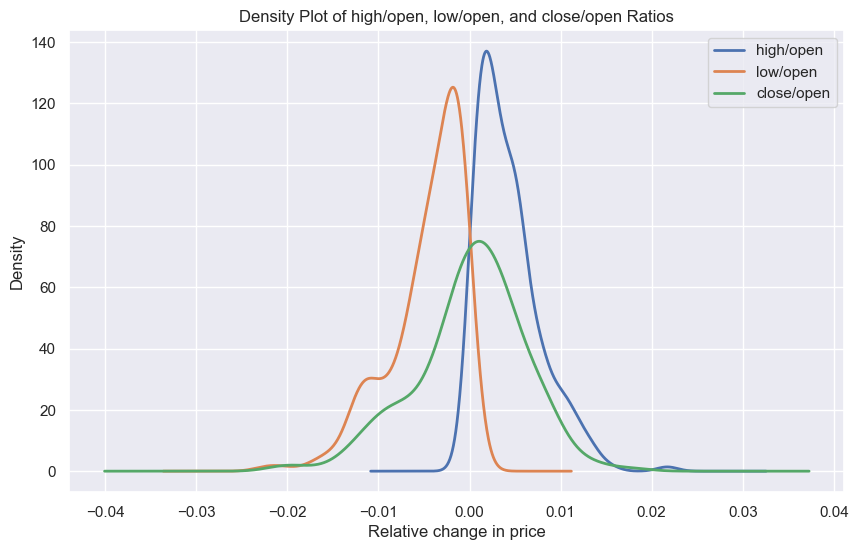

In [7]:
def daily_range_ci(df_stock):
	"""
	Plot the daily stock price range distribution, and return the 95% confidence interval
	input:
		df_stock: daily stock price; with columns lower cased
	"""
	print(
		'high - open 95% confidence value:',
		((df_stock['high']-df_stock['open'])/df_stock['open']).quantile(q=0.95)
		)
	print(
		'low - open 95% confidence value:',
		((df_stock['low']-df_stock['open'])/df_stock['open']).quantile(q=0.05)
		)
	print(
		'close - open 95% confidence values - two-tail, using percentile:',
		((df_stock['close']-df_stock['open'])/df_stock['open']).quantile(q=0.025),
		((df_stock['close']-df_stock['open'])/df_stock['open']).quantile(q=0.975)
		)
	print(
		'close - open 95% confidence values - two-tail, using normal distribution:',
		((df_stock['close'] - df_stock['open']) / df_stock['open']).mean() - 1.96*((df_stock['close'] - df_stock['open']) / df_stock['open']).std(),
		((df_stock['close'] - df_stock['open']) / df_stock['open']).mean() + 1.96*((df_stock['close'] - df_stock['open']) / df_stock['open']).std(),
		)


	plt.figure(figsize=(10, 6))
	# Density plot for high_open_ratio
	((df_stock['high']-df_stock['open'])/df_stock['open']).plot(kind='density', label='high/open', linewidth=2)

	# Density plot for low_open_ratio
	((df_stock['low']-df_stock['open'])/df_stock['open']).plot(kind='density', label='low/open', linewidth=2)

	# Density plot for close_open_ratio
	((df_stock['close']-df_stock['open'])/df_stock['open']).plot(kind='density', label='close/open', linewidth=2)

	plt.xlabel('Relative change in price')
	plt.ylabel('Density')
	plt.title('Density Plot of high/open, low/open, and close/open Ratios')
	plt.legend()
	plt.show()





df_spy = yf.download('spy'.upper(),
                     start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                     end=datetime.today().strftime('%Y-%m-%d'))
df_spy = df_spy.reset_index()
df_spy.columns = df_spy.columns.str.lower()

daily_range_ci(df_spy)

## Geometric Brownian motion - exploration

Given historical stock price, one can
1. Estimate the drift and volatility using mean and std of daily stock relative change
   * because dS = mu*S*dt + sigma*S*dW, so dS/S = mu*dt + sigma*dW, and mean(dS/S) = mu*dt, std(dS/S) = sigma*sqrt(dt). One can set dt = 1 and use mean and std of dS/S to calculate mu and sigma 
2. Fit the stock price to the Geometric Brownian motion model, and use MLE to estimate mu and sigma.
   * likelihood of having n observation of S where S follow geometric Brownian motion: Pi PDE(S|mu, sigma), so log-likelihood = sum(log(PDE(S|mu, sigma)); plug in the probability density function and take the log yield the log-likelihood function.

In [8]:
df_spy = yf.download('spy'.upper(),
                     start=(datetime.today() - relativedelta(years=10)).strftime('%Y-%m-%d'),
                     end=datetime.today(),
                    )
df_spy = df_spy.reset_index()
df_spy.columns = df_spy.columns.str.lower()
print(df_spy.shape)
df_spy.head()

[*********************100%%**********************]  1 of 1 completed

(2517, 7)


,date,open,high,low,close,adj close,volume
0,2014-07-28,197.759995,198.089996,196.619995,197.800003,165.561371,69259000
1,2014-07-29,198.169998,198.449997,196.919998,196.949997,164.849869,80466000
2,2014-07-30,197.649994,197.910004,196.160004,196.979996,164.874985,104222000
3,2014-07-31,195.610001,195.779999,192.970001,193.089996,161.618988,183479000
4,2014-08-01,192.559998,193.759995,191.570007,192.500000,161.125137,189261000


##### Method 1

In [9]:
daily_returns = np.diff(df_spy['close']) / df_spy['close'][0:-1]
print(len(daily_returns))
print("Estimate drift:", daily_returns.mean())
print("Estimate volatility:", daily_returns.std())

2516
Estimate drift: 0.00046408513855361
Estimate volatility: 0.011108298284291582


##### Method 2

In [10]:
# Generate synthetic daily stock price data for demonstration
np.random.seed(42)  # for reproducibility
num_days = df_spy.shape[0]  
initial_price = df_spy['close'][0]
drift = daily_returns.mean()  # initial guess for drift, passing the estimated drift
volatility = daily_returns.std()  # initial guess for volatility, passing the estimated volatility

# Generate synthetic daily stock price data
def generate_stock_prices(drift, volatility, initial_price, num_days):
    daily_returns = np.exp((drift - 0.5 * volatility**2) + volatility * norm.ppf(np.random.rand(num_days)))
    stock_prices = initial_price * pd.Series(daily_returns.cumprod(), name='Close')
    return stock_prices

# Log-likelihood function for GBM
def gbm_log_likelihood(params, prices):
    mu, sigma = params
    dt = 1  # time increment (1 day)
    returns = np.diff(np.log(prices))
    ll = -len(returns) / 2 * np.log(2 * np.pi) - len(returns) / 2 * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * np.sum((returns - (mu - 0.5 * sigma ** 2) * dt) ** 2)
    return -ll

# Fit GBM parameters using MLE
def fit_gbm_params(prices):
    initial_guess = [0.05, 0.2]  # initial guess for drift and volatility
    result = minimize(gbm_log_likelihood, initial_guess, args=(prices,), bounds=((None, None), (0.001, None)))
    mu_mle, sigma_mle = result.x
    return mu_mle, sigma_mle

In [11]:
drift_mle, volatility_mle = fit_gbm_params(df_spy['close'])
print('Drift:', drift_mle)
print('Volatility:', volatility_mle)

Drift: 0.00046446321592546737
Volatility: 0.011144388036721024


In [12]:
estimated_prices = generate_stock_prices(drift_mle, volatility_mle, initial_price, num_days)
estimated_prices

0       197.175509
1       200.919659
2       202.391561
3       203.037628
4       200.843741
           ...    
2512    531.245023
2513    531.613743
2514    533.744585
2515    542.654102
2516    530.478443
Name: Close, Length: 2517, dtype: float64

In [13]:
expectation_return = initial_price*np.exp(drift_mle*np.arange(start=0, stop=num_days))
expectation_return

array([197.80000305, 197.89189522, 197.98383007, ..., 635.82092514,
       636.11630917, 636.41183042])

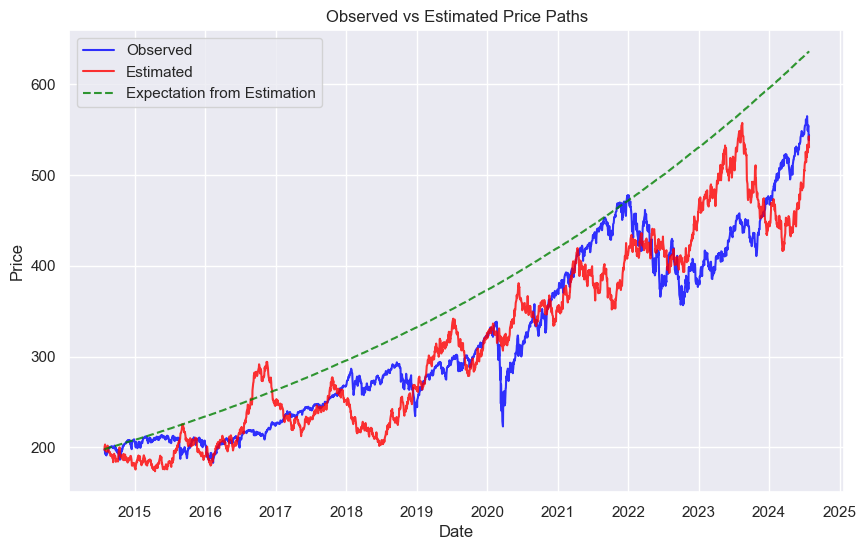

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df_spy['date'], df_spy['close'], label='Observed', color='blue', alpha=0.8)
plt.plot(df_spy['date'], estimated_prices.values, label='Estimated', color='red', alpha=0.8)
plt.plot(df_spy['date'], expectation_return, label='Expectation from Estimation', color='green',linestyle='--', alpha=0.8)

plt.title('Observed vs Estimated Price Paths')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## MACD - exploration

1. Calculate EMA-26D and EMA-12D of daily stock price
2. MACD = EMA-12D - EMA-26D
3. Calculate EMA-9D of MACD to represent the recent trend of MACD -- this is the signal line.
4. Compare MACD to the signal line. MACD crosses signal line from below indicates an uptrend, and vice versa.

In [15]:
# # Simulation

# dates = pd.date_range(start='2020-01-01', end='2020-03-01', freq='D')

# np.random.seed(0)  # for reproducibility
# prices = np.concatenate([np.linspace(100, 80, 31), np.linspace(80, 90, 30)])

# prices_series = pd.Series(prices, index=dates)

# # Calculate EMAs
# ema_12 = prices_series.ewm(span=12, adjust=False).mean()
# ema_26 = prices_series.ewm(span=26, adjust=False).mean()

# # Calculate MACD line
# macd_line = ema_12 - ema_26

# # Calculate signal line (9-period EMA of MACD line)
# signal_line = macd_line.ewm(span=9, adjust=False).mean()

# # Visualization
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# # Plot daily stock price and EMAs
# ax1.plot(prices_series.index, prices_series, label='Price', color='blue')
# ax1.plot(ema_12.index, ema_12, label='12-day EMA', linestyle='--', color='orange')
# ax1.plot(ema_26.index, ema_26, label='26-day EMA', linestyle='--', color='green')
# ax1.set_title('Daily Stock Price and EMAs')
# ax1.legend()

# # Plot MACD and signal line, color bars based on MACD above/below signal line
# ax2.plot(macd_line.index, macd_line, label='MACD', color='red')
# ax2.plot(signal_line.index, signal_line, label='Signal Line', linestyle='--', color='blue')

# # Determine bar colors based on MACD and signal line relationship
# bar_colors = ['green' if macd > signal else 'red' for macd, signal in zip(macd_line, signal_line)]
# ax2.bar(macd_line.index, macd_line - signal_line, width=0.5, align='center', color=bar_colors)

# ax2.set_title('MACD')
# ax2.legend()

# # Add x-axis label between the subplots
# fig.suptitle('MACD Analysis', fontsize=16)
# fig.subplots_adjust(hspace=0.05)  # Reduce vertical space between subplots
# plt.xticks(rotation=45) 

# plt.tight_layout()
# plt.show()

In [16]:
def plot_macd(
    stock_name,
    start=(datetime.today() - relativedelta(months=18)).strftime('%Y-%m-%d'),
    end=datetime.today(),
    figsize=(8, 8)):
    '''
    Input:
    stock_name: str
    start: datetime
    end: datetime
    figsize: size of plot
    '''
    df = yf.download(stock_name.upper(),
                     start=start,
                     end=end)
    df = df.reset_index()
    df.columns = df.columns.str.lower()
    df['date'] = pd.to_datetime(df['date'])

    # Calculate MA and Bollinger Bands
    df['20 Day MA'] = df['close'].rolling(window=20).mean()
    df['20 Day STD'] = df['close'].rolling(window=20).std()
    df['50 Day MA'] = df['close'].rolling(window=50).mean()
    df['50 Day STD'] = df['close'].rolling(window=50).std()        
    # Calculate upper and lower bands
    df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
    df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)
    
    # Calculate EMAs
    df_plot = df[df['date'] >= df['date'].min() + relativedelta(years=1)]
    df_plot = df_plot.set_index('date')
    prices_series = df_plot['close']
    ema_12 = prices_series.ewm(span=12, adjust=False).mean()
    ema_26 = prices_series.ewm(span=26, adjust=False).mean()
    
    # Calculate MACD line
    macd_line = ema_12 - ema_26
    
    # Calculate signal line (9-period EMA of MACD line)
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    
    # Plot daily stock price & MAs & EMAs
    ax1.plot(prices_series.index, prices_series, label='Price')
    ax1.plot(df_plot.index, df_plot['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax1.plot(df_plot.index, df_plot['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
    ax1.plot(df_plot.index, df_plot['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
    ax1.fill_between(df_plot.index, df_plot['Upper Band - 20MA'], df_plot['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
    ax1.plot(df_plot.index, df_plot['50 Day MA'], ls='--', label='50 Day Moving Average')
    ax1.plot(df_plot.index, df_plot['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
    ax1.plot(df_plot.index, df_plot['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
    ax1.fill_between(df_plot.index, df_plot['Upper Band - 50MA'], df_plot['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

    # ax1.plot(ema_12.index, ema_12, label='12-day EMA', linestyle='--', color='orange')
    # ax1.plot(ema_26.index, ema_26, label='26-day EMA', linestyle='--', color='green')
    
    ax1.set_title('Daily Stock Price')
    ax1.legend()
    
    # Plot MACD and signal line, color bars based on MACD above/below signal line
    ax2.plot(macd_line.index, macd_line, label='MACD', color='red')
    ax2.plot(signal_line.index, signal_line, label='Signal Line', linestyle='--', color='blue')
    
    # Determine bar colors based on MACD and signal line relationship
    bar_colors = ['green' if macd > signal else 'red' for macd, signal in zip(macd_line, signal_line)]
    ax2.bar(macd_line.index, macd_line - signal_line, width=1.5, align='center', color=bar_colors)
    
    ax2.set_title('MACD')
    ax2.legend()
    
    # Add x-axis label between the subplots
    fig.suptitle('MACD Analysis', fontsize=16)
    fig.subplots_adjust(hspace=0.05)  # Reduce vertical space between subplots
    plt.xticks(rotation=45) 
    
    plt.tight_layout()
    plt.show()

[*********************100%%**********************]  1 of 1 completed


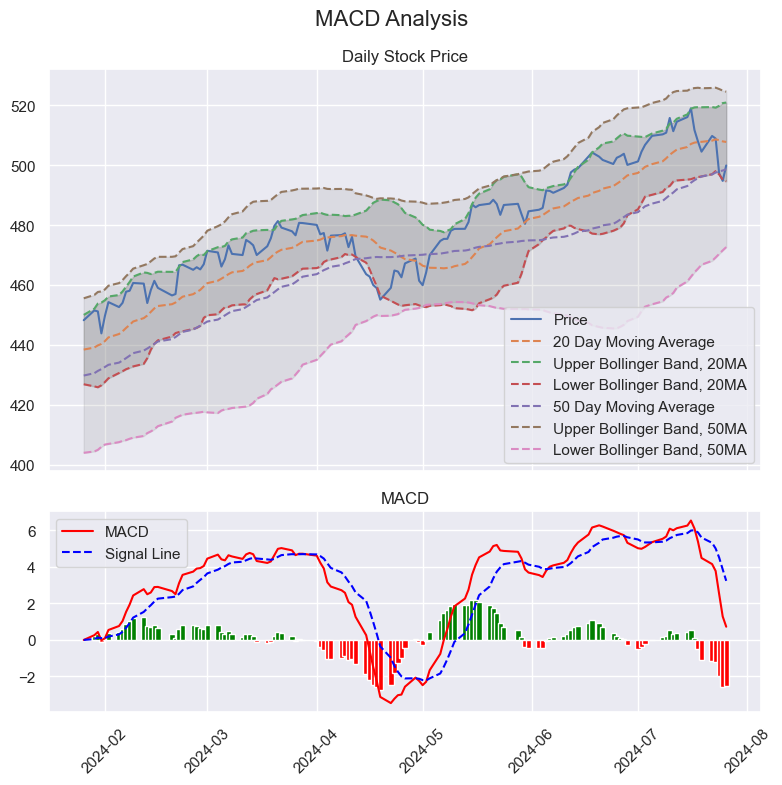

In [17]:
plot_macd('voo')

## ML

### Gradiant Boosting

#### Regression

In [18]:
# Data import
data = yf.download('VOO', start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
data = data.reset_index()
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(503, 6)


,open,high,low,close,adj close,volume
date,,,,,,
2022-07-26,362.119995,362.209991,358.450012,359.250000,347.976746,2987200
2022-07-27,362.489990,370.329987,362.220001,368.660004,357.091522,4500300
2022-07-28,369.420013,373.910004,365.980011,373.320007,361.605255,4345300
2022-07-29,374.730011,379.660004,373.929993,378.790009,366.903625,5246400
2022-08-01,376.119995,380.010010,375.440002,377.649994,365.799408,4421400


In [19]:
for lag in range(1, 8):
    data[f'Close_lag_{lag}'] = data['close'].shift(lag)
    data[f'Volume_lag_{lag}'] = data['volume'].shift(lag)

# Moving Averages (shift by 1 to avoid data leakage)
data['SMA_5'] = data['close'].rolling(window=5).mean().shift(1)
data['SMA_10'] = data['close'].rolling(window=10).mean().shift(1)
# data['SMA_20'] = data['close'].rolling(window=20).mean().shift(1) # same as data['Middle_Band']

data['EMA_5'] = data['close'].ewm(span=5, adjust=False).mean().shift(1)
data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean().shift(1)
data['EMA_20'] = data['close'].ewm(span=20, adjust=False).mean().shift(1)

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean().shift(1)
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean().shift(1)
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['Middle_Band'] = data['close'].rolling(window=20).mean().shift(1)
data['Upper_Band'] = data['Middle_Band'] + 2 * data['close'].rolling(window=20).std().shift(1)
data['Lower_Band'] = data['Middle_Band'] - 2 * data['close'].rolling(window=20).std().shift(1)

# Volume-based features
data['Volume_SMA_5'] = data['volume'].rolling(window=5).mean().shift(1)
data['Volume_SMA_10'] = data['volume'].rolling(window=10).mean().shift(1)
data['Volume_SMA_20'] = data['volume'].rolling(window=20).mean().shift(1)

# Date features
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month

# Drop rows with NaN values generated by rolling and shifting operations
data.dropna(inplace=True)
print(data.shape)
data.head()

(483, 34)


,open,high,low,close,adj close,volume,Close_lag_1,Volume_lag_1,Close_lag_2,Volume_lag_2,...,EMA_20,RSI_14,Middle_Band,Upper_Band,Lower_Band,Volume_SMA_5,Volume_SMA_10,Volume_SMA_20,Day_of_Week,Month
date,,,,,,,,,,,,,,,,,,,,,
2022-08-23,379.559998,381.869995,378.519989,379.040009,367.145752,2869200,379.940002,4153700.0,388.119995,2899000.0,...,382.002853,55.473284,382.030502,400.523722,363.537282,3479580.0,3385310.0,3652730.0,1,8
2022-08-24,378.899994,381.579987,378.179993,380.190002,368.259674,2241200,379.040009,2869200.0,379.940002,4153700.0,...,381.720678,47.346405,383.020003,398.202442,367.837563,3280460.0,3436180.0,3646830.0,2,8
2022-08-25,381.760010,385.730011,380.700012,385.730011,373.625854,2631300,380.190002,2241200.0,379.040009,2869200.0,...,381.574899,49.258328,383.596503,397.285207,369.907798,3084240.0,3295200.0,3533875.0,3,8
2022-08-26,385.549988,386.049988,372.510010,372.510010,360.820648,5153200,385.730011,2631300.0,380.190002,2241200.0,...,381.970624,56.556446,384.217003,397.042168,371.391838,2958880.0,3200790.0,3448175.0,4,8
2022-08-29,369.769989,373.049988,368.779999,370.049988,358.437836,4953200,372.510010,5153200.0,385.730011,2631300.0,...,381.069613,43.715841,383.903003,397.567653,370.238353,3409720.0,3349670.0,3443515.0,0,8


In [20]:
features = data.drop(columns=['close', 'open', 'high', 'low', 'adj close', 'volume'])
print(features.shape)
print(features.isna().sum())
target = data['close']
print(target.shape)
print(target.isna().sum())


(483, 28)
Close_lag_1      0
Volume_lag_1     0
Close_lag_2      0
Volume_lag_2     0
Close_lag_3      0
Volume_lag_3     0
Close_lag_4      0
Volume_lag_4     0
Close_lag_5      0
Volume_lag_5     0
Close_lag_6      0
Volume_lag_6     0
Close_lag_7      0
Volume_lag_7     0
SMA_5            0
SMA_10           0
EMA_5            0
EMA_10           0
EMA_20           0
RSI_14           0
Middle_Band      0
Upper_Band       0
Lower_Band       0
Volume_SMA_5     0
Volume_SMA_10    0
Volume_SMA_20    0
Day_of_Week      0
Month            0
dtype: int64
(483,)
0


In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a GBM model
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_train, model.predict(X_train))
print(f'Mean Squared Error, train: {mse}')
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error, test: {mse}')

Mean Squared Error, train: 0.8209134357368545
Mean Squared Error, test: 20.955452951055367


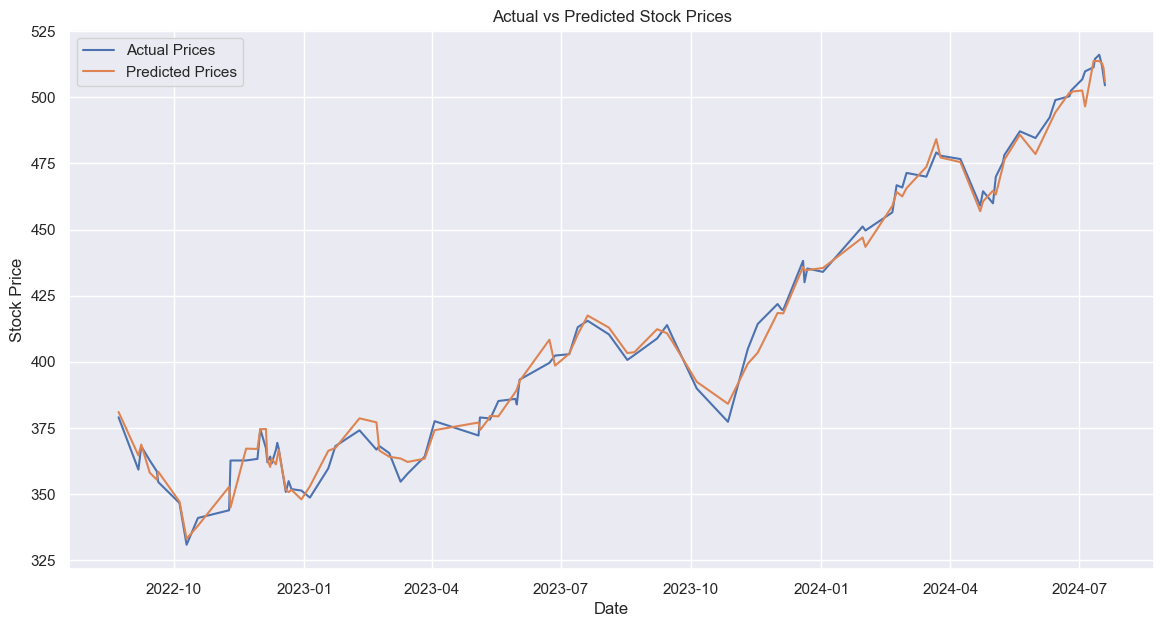

In [22]:
df_plot = pd.DataFrame()
df_plot['date'] = y_test.index
df_plot['actual'] = y_test.tolist()
df_plot['pred'] = predictions
df_plot.sort_values(by='date',inplace=True)
plt.figure(figsize=(14, 7))
plt.plot(df_plot['date'] , df_plot['actual'] , label='Actual Prices')
plt.plot(df_plot['date'] , df_plot['pred'] , label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()


<Axes: title={'center': 'Feature Importance'}, xlabel='F score', ylabel='Features'>

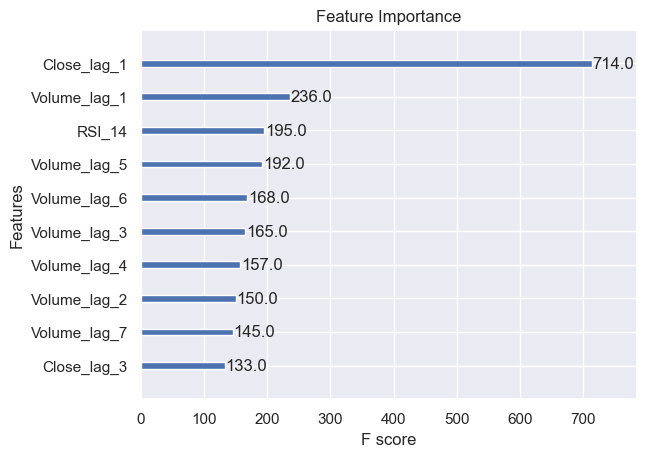

In [23]:
xgb.plot_importance(model, importance_type='weight', max_num_features=10, title='Feature Importance')

Build size: 434
OOT size: 49
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': 1.0}
Best cross-validation score (MSE): 225.91649560261848
Mean Squared Error on Out-of-Time Test Set: 602.4927799202958


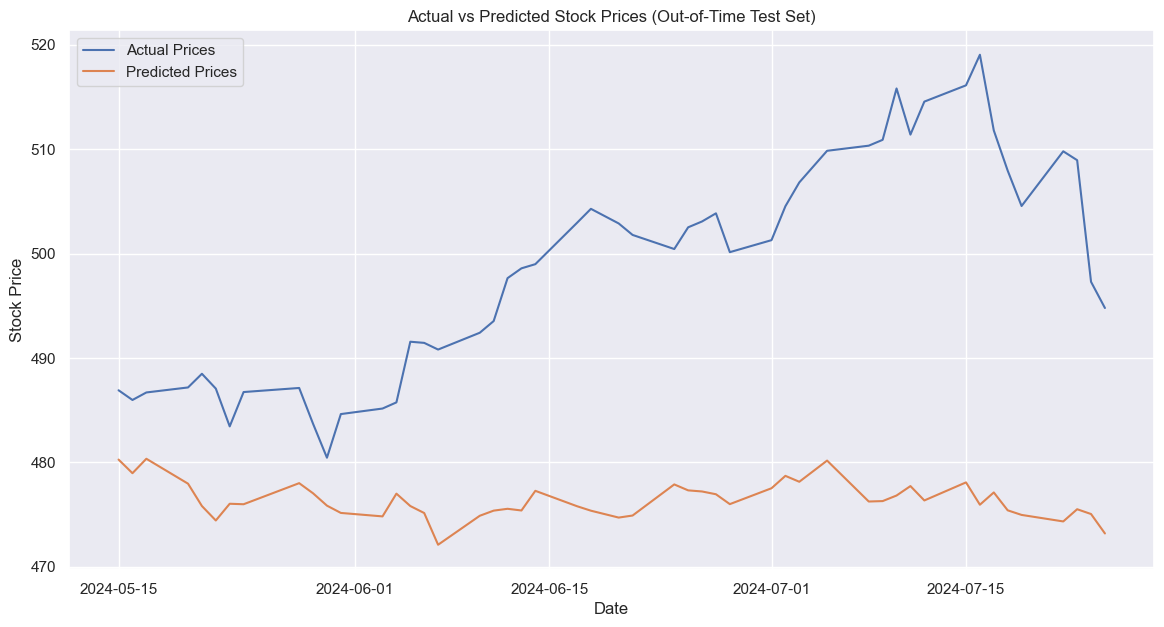

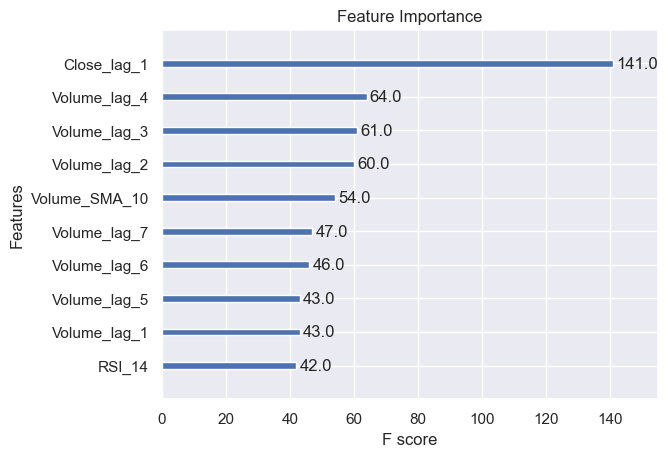

In [24]:
X_build, X_oot, y_build, y_oot = train_test_split(data.drop(columns=['close', 'open', 'high', 'low', 'adj close', 'volume']), 
                                                  data['close'], 
                                                  test_size=0.1, 
                                                  shuffle=False)
print('Build size:', len(y_build))
print('OOT size:', len(y_oot))

# Fine-tune the model using GridSearchCV with 5-fold cross-validation
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_build, y_build)

# Report cross-validation model performance
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score (MSE): {-grid_search.best_score_}')

# Apply the optimal model to the out-of-time test set
optimal_model = grid_search.best_estimator_
y_oot_pred = optimal_model.predict(X_oot)

# Evaluate the model on the out-of-time test set
oot_mse = mean_squared_error(y_oot, y_oot_pred)
print(f'Mean Squared Error on Out-of-Time Test Set: {oot_mse}')

# Plotting y_oot and y_oot_pred
plt.figure(figsize=(14, 7))
plt.plot(y_oot.index, y_oot, label='Actual Prices')
plt.plot(y_oot.index, y_oot_pred, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices (Out-of-Time Test Set)')
plt.legend()
plt.show()

# Plot feature importance
xgb.plot_importance(optimal_model, importance_type='weight', max_num_features=10, title='Feature Importance')
plt.show()

#### Classification

In [25]:
# Data import
data = yf.download('VOO', start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
data = data.reset_index()
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(503, 6)


,open,high,low,close,adj close,volume
date,,,,,,
2022-07-26,362.119995,362.209991,358.450012,359.250000,347.976746,2987200
2022-07-27,362.489990,370.329987,362.220001,368.660004,357.091522,4500300
2022-07-28,369.420013,373.910004,365.980011,373.320007,361.605255,4345300
2022-07-29,374.730011,379.660004,373.929993,378.790009,366.903625,5246400
2022-08-01,376.119995,380.010010,375.440002,377.649994,365.799408,4421400


In [26]:
# create binary target: if the stock price goes 3% higher or more in the next 20 days then 1, otherwise 0 
data['Max_Close_Next_20_Days'] = data['close'].rolling(window=20, min_periods=1).max().shift(-20)
data['target'] = np.where(data['Max_Close_Next_20_Days'] >= data['close'] * 1.03, 1, 0)
data.dropna(subset=['Max_Close_Next_20_Days'], inplace=True)
print(data.shape)
data['target'].tail(21)

(483, 8)


date
2024-05-28    1
2024-05-29    1
2024-05-30    1
2024-05-31    1
2024-06-03    1
2024-06-04    1
2024-06-05    1
2024-06-06    1
2024-06-07    1
2024-06-10    1
2024-06-11    1
2024-06-12    1
2024-06-13    1
2024-06-14    1
2024-06-17    1
2024-06-18    0
2024-06-20    1
2024-06-21    1
2024-06-24    1
2024-06-25    1
2024-06-26    1
Name: target, dtype: int64

In [27]:
# features
for lag in range(1, 8):
    data[f'Close_lag_{lag}'] = data['close'].shift(lag)
    data[f'Volume_lag_{lag}'] = data['volume'].shift(lag)

# Moving Averages (shift by 1 to avoid data leakage)
data['SMA_5'] = data['close'].rolling(window=5).mean().shift(1)
data['SMA_10'] = data['close'].rolling(window=10).mean().shift(1)
# data['SMA_20'] = data['close'].rolling(window=20).mean().shift(1) # same as data['Middle_Band']

data['EMA_5'] = data['close'].ewm(span=5, adjust=False).mean().shift(1)
data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean().shift(1)
data['EMA_20'] = data['close'].ewm(span=20, adjust=False).mean().shift(1)

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean().shift(1)
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean().shift(1)
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['Middle_Band'] = data['close'].rolling(window=20).mean().shift(1)
data['Upper_Band'] = data['Middle_Band'] + 2 * data['close'].rolling(window=20).std().shift(1)
data['Lower_Band'] = data['Middle_Band'] - 2 * data['close'].rolling(window=20).std().shift(1)

# Volume-based features
data['Volume_SMA_5'] = data['volume'].rolling(window=5).mean().shift(1)
data['Volume_SMA_10'] = data['volume'].rolling(window=10).mean().shift(1)
data['Volume_SMA_20'] = data['volume'].rolling(window=20).mean().shift(1)

# Date features
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month

# Drop rows with NaN values generated by rolling and shifting operations
data.dropna(inplace=True)
print(data.shape)
data.head()

(463, 36)


,open,high,low,close,adj close,volume,Max_Close_Next_20_Days,target,Close_lag_1,Volume_lag_1,...,EMA_20,RSI_14,Middle_Band,Upper_Band,Lower_Band,Volume_SMA_5,Volume_SMA_10,Volume_SMA_20,Day_of_Week,Month
date,,,,,,,,,,,,,,,,,,,,,
2022-08-23,379.559998,381.869995,378.519989,379.040009,367.145752,2869200,385.730011,0,379.940002,4153700.0,...,382.002853,55.473284,382.030502,400.523722,363.537282,3479580.0,3385310.0,3652730.0,1,8
2022-08-24,378.899994,381.579987,378.179993,380.190002,368.259674,2241200,385.730011,0,379.040009,2869200.0,...,381.720678,47.346405,383.020003,398.202442,367.837563,3280460.0,3436180.0,3646830.0,2,8
2022-08-25,381.760010,385.730011,380.700012,385.730011,373.625854,2631300,377.859985,0,380.190002,2241200.0,...,381.574899,49.258328,383.596503,397.285207,369.907798,3084240.0,3295200.0,3533875.0,3,8
2022-08-26,385.549988,386.049988,372.510010,372.510010,360.820648,5153200,377.859985,0,385.730011,2631300.0,...,381.970624,56.556446,384.217003,397.042168,371.391838,2958880.0,3200790.0,3448175.0,4,8
2022-08-29,369.769989,373.049988,368.779999,370.049988,358.437836,4953200,377.859985,0,372.510010,5153200.0,...,381.069613,43.715841,383.903003,397.567653,370.238353,3409720.0,3349670.0,3443515.0,0,8


In [28]:
features = data.drop(columns=['close', 'open', 'high', 'low', 'adj close', 'volume', 'Max_Close_Next_20_Days', 'target'])
print(features.shape)
print(features.isna().sum())
target = data['target']
print(target.shape)
print(target.isna().sum())

(463, 28)
Close_lag_1      0
Volume_lag_1     0
Close_lag_2      0
Volume_lag_2     0
Close_lag_3      0
Volume_lag_3     0
Close_lag_4      0
Volume_lag_4     0
Close_lag_5      0
Volume_lag_5     0
Close_lag_6      0
Volume_lag_6     0
Close_lag_7      0
Volume_lag_7     0
SMA_5            0
SMA_10           0
EMA_5            0
EMA_10           0
EMA_20           0
RSI_14           0
Middle_Band      0
Upper_Band       0
Lower_Band       0
Volume_SMA_5     0
Volume_SMA_10    0
Volume_SMA_20    0
Day_of_Week      0
Month            0
dtype: int64
(463,)
0


<Axes: ylabel='Frequency'>

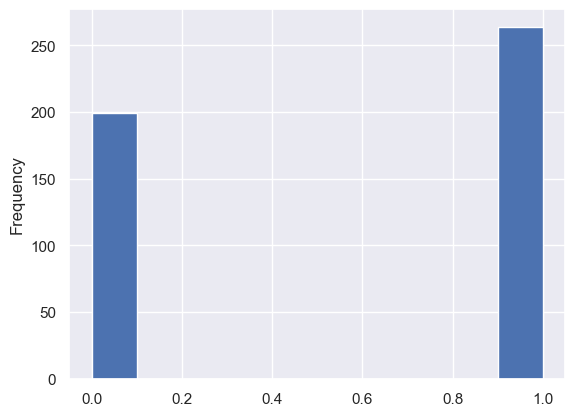

In [29]:
data['target'].plot(kind='hist')

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a GBM model
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate accuracy and AUC-ROC score
precision = precision_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print(f'Precision on test set: {precision:.4f}')
print(f'AUC-ROC score on test set: {auc_roc:.4f}')
print(f'F1 score on test set: {f1:.4f}')

Precision on test set: 0.8276
AUC-ROC score on test set: 0.9057
F1 score on test set: 0.8807


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/opt/anaconda3/envs/ts_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ts_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ts_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ts_en

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score (AUC): 0.8040572877602772
Precision on test set: 0.5139
AUC-ROC score on test set: 0.3857
F1 score on test set: 0.5736


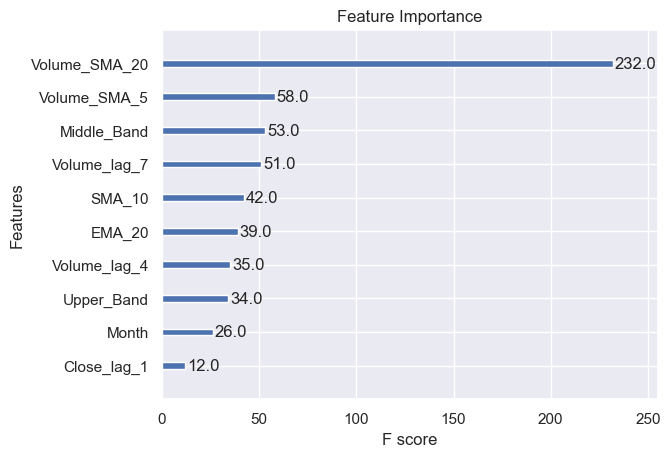

In [31]:
X_build, X_oot, y_build, y_oot = train_test_split(features, target, test_size=0.2, shuffle=False)

# Fine-tune the model using GridSearchCV with 5-fold cross-validation
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBClassifier(objective='binary:logistic')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1)

grid_search.fit(X_build, y_build)

# Report cross-validation model performance
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score (AUC): {grid_search.best_score_}')

# Apply the optimal model to the out-of-time test set
optimal_model = grid_search.best_estimator_
y_oot_pred = optimal_model.predict(X_oot)
y_oot_pred_proba = optimal_model.predict_proba(X_oot)[:, 1]

# Calculate accuracy and AUC-ROC score
f1 = f1_score(y_oot, y_oot_pred)
precision = precision_score(y_oot, y_oot_pred)
auc_roc = roc_auc_score(y_oot, y_oot_pred_proba)

print(f'Precision on test set: {precision:.4f}')
print(f'AUC-ROC score on test set: {auc_roc:.4f}')
print(f'F1 score on test set: {f1:.4f}')

# Plot feature importance
xgb.plot_importance(optimal_model, importance_type='weight', max_num_features=10, title='Feature Importance')
plt.show()

### LSTM

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Data import
data = yf.download('VOO', start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
data = data.reset_index()
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(503, 6)


,open,high,low,close,adj close,volume
date,,,,,,
2022-07-26,362.119995,362.209991,358.450012,359.250000,347.976746,2987200
2022-07-27,362.489990,370.329987,362.220001,368.660004,357.091522,4500300
2022-07-28,369.420013,373.910004,365.980011,373.320007,361.605255,4345300
2022-07-29,374.730011,379.660004,373.929993,378.790009,366.903625,5246400
2022-08-01,376.119995,380.010010,375.440002,377.649994,365.799408,4421400


In [33]:
# create binary target: if the stock price goes 3% higher or more in the next 20 days then 1, otherwise 0 
data['Max_Close_Next_20_Days'] = data['close'].rolling(window=20, min_periods=1).max().shift(-20)
data['target'] = np.where(data['Max_Close_Next_20_Days'] >= data['close'] * 1.03, 1, 0)
data.dropna(subset=['Max_Close_Next_20_Days'], inplace=True)
print(data.shape)
data['target'].tail(21)

(483, 8)


date
2024-05-28    1
2024-05-29    1
2024-05-30    1
2024-05-31    1
2024-06-03    1
2024-06-04    1
2024-06-05    1
2024-06-06    1
2024-06-07    1
2024-06-10    1
2024-06-11    1
2024-06-12    1
2024-06-13    1
2024-06-14    1
2024-06-17    1
2024-06-18    0
2024-06-20    1
2024-06-21    1
2024-06-24    1
2024-06-25    1
2024-06-26    1
Name: target, dtype: int64